In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pyreadr

# to plot interaction networks of As and Ss; must be version >= 3.0 due to
# an update to MatPlotLib
from scipy.stats import nbinom
import statsmodels.api as sm
from statsmodels.formula.api import glm
import anndata as ad

from scipy.sparse import coo_matrix, csc_matrix

PAM50genes = [
    "EGFR",    "CDH3",
    "PHGDH",    "ACTR3B",
    "FOXC1",    "MIA",
    "MYC",    "FGFR4",
    "MDM2",    "MLPH",
    "KRT14",    "BCL2",
    "SFRP1",    "KRT5",
    "KRT17",    "SLC39A6",
    "ESR1",    "CXXC5",
    "BLVRA",    "FOXA1",
    "GPR160",    "NAT1",
    "MAPT",    "PGR",
    "BAG1",    "TMEM45B",
    "ERBB2",    "GRB7",
    "MMP11",    "CDC20",
    "MKI67",    "CCNE1",
    "CENPF",    "NUF2",
    "EXO1",    "KIF2C",
    "ORC6",    "ANLN",
    "CDC6",    "RRM2",
    "UBE2T",    "NDC80",
    "CEP55",    "MELK",
    "TYMS",    "CCNB1",
    "BIRC5",    "MYBL2",
    "PTTG1",    "UBE2C"
]

First we need to compute the omega values from the DCIS dataset 

In [ ]:
path_to_data = "/path/to/datasets//"
data_folder = "dcis"
dataset = "/train_validation/expression_counts.Jan2023_1_2_and_2_2_19K.tau_1.h5ad"


anndata_test = ad.read_h5ad(path_to_data + data_folder + dataset)
expr_matrix = anndata_test.X
gene_order = anndata_test.var['gene']

subtype_info = anndata_test.obs['subtype']

# checking if matrix given is a tensor or a numpy array
if isinstance(expr_matrix, np.ndarray):
    cleaned_matrix = np.nan_to_num(expr_matrix)
else:
    cleaned_matrix = np.nan_to_num(expr_matrix.detach().cpu().numpy())


#### TURN TO OMEGA VALUES #####
#anndata_test.obs['library_size'] = anndata_test.X.sum(axis=1)

#cleaned_matrix = (cleaned_matrix / anndata_test.obs['library_size'].values[:, None])
# no we will compute omega of just PAM50



In [ ]:
# Gene Name Conversion
file = "/path/to/data/ensemble_to_refseq_gene_name_table.rds"

gene_converter = pyreadr.read_r(file)
gene_converter = gene_converter[None]

# only do this step if gene names are all Ensemble genes
all_start_with_ENSG = all(gene_id.startswith('ENSG') for gene_id in gene_order)

if (all_start_with_ENSG):
    filtered_df = gene_converter[gene_converter['gene_id'].isin(gene_order)]
    gene_mapping = pd.Series(filtered_df.gene_name.values,index=filtered_df.gene_id).to_dict()

    gene_ids_list = [gene_mapping[gene_name] for gene_name in gene_order if gene_name in gene_mapping]

    gene_order = gene_ids_list

In [4]:
# normalize library size
anndata_test.obs['library_size'] = anndata_test.X.sum(axis=1)

In [5]:

# which gene_order are in PAM50_genes; no repeat genes in AnnData tables
if gene_order is not None:
    gene_indices = {gene: index for index, gene in enumerate(gene_order)}
    gene_match = [
        gene_indices[gene] if gene in gene_indices else None for gene in PAM50genes
    ]

    indices = [index for index in gene_match if index is not None]

    present_pam50 = [
        gene for gene, idx in zip(PAM50genes, gene_match) if idx is not None
    ]

    cleaned_matrix = cleaned_matrix[:, indices]
    print("PAM50 Genes Found: ", len(cleaned_matrix[0]))

    missing_pam50 = [
        gene for gene, idx in zip(PAM50genes, gene_match) if idx is None
    ]

    # Print missing PAM50 genes
    print("Missing PAM50 Genes: ", missing_pam50)
else:
    print("Missing names of genes (required)")

# I want to normalize over all samples


df = pd.DataFrame(cleaned_matrix)

pam50_lib_size = df.sum(axis=1)

##### THIS IS WHERE MU IS CHANGED FROM COUNTS TO OMEGA
cleaned_matrix = (cleaned_matrix / pam50_lib_size.values[:, None])

#### USE THIS OPTION FOR NORMALIZED LIBRARY COUNTS
#cleaned_matrix = (cleaned_matrix / pam50_lib_size.values[:, None])*100000

PAM50 Genes Found:  50
Missing PAM50 Genes:  []


In [ ]:
# parameters 
print(df.shape)

trim_percent = 0

(229, 50)


In [ ]:
# now lets draw the PAM50 distribution on a per-subtype basis
count = 0
df_final = pd.DataFrame(columns=['Gene', 'Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"])

# added feature: Draw histograms and NB parameters of PAM50 genes


for gene in present_pam50:
        gene_data = cleaned_matrix[:, count].flatten()
        count = count + 1
        
        # we split data by subtype
        data = pd.DataFrame({
            'Numbers': gene_data,
            'Categories': subtype_info
        })
        grouped = data.groupby('Categories')['Numbers'].apply(list)

        

        for subtype, subtype_expression in grouped.items():
            if (subtype == "NaN"):
                continue
            
            n = len(subtype_expression)
            trim_percent = 0
            elements_to_trim = int(np.floor(trim_percent / 100.0 * n))  
            sorted_data = np.sort(subtype_expression)
            
            if (elements_to_trim > 0):
               print (elements_to_trim)
               subtype_expression = sorted_data[elements_to_trim:-elements_to_trim]

            if(gene == "ERBB2"):
                 print(subtype)
                 print(subtype_expression)

            # calculate NB parameters
            mu = np.mean(subtype_expression)
            variance = np.var(subtype_expression, ddof=1)

            # Calculate dispersion parameter (theta) using method of moments
            theta = mu**2 / (variance - mu)

            # somehow the r paramater is computed the same way
            r = mu**2 / (variance - mu)
            p = r / (r + mu)
            
            x = np.arange(0, np.max(subtype_expression) + 1)  # Range of values
            pmf = nbinom.pmf(x, r, p)

            # getting a summary description of the NB parameters using statsmodels.api
            X = np.ones_like(subtype_expression)
            model = sm.NegativeBinomial(subtype_expression, X)
            results = model.fit(disp=0)

            p_values = results.pvalues
            coeffs = results.params


            df = pd.DataFrame({
                'Parameter': ['Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"],
                'Value': [mu, variance, round(theta, 5), round(p, 5), round(r, 5), round(coeffs[0], 4), round(p_values[0], 5), round(coeffs[1],4), round(p_values[1],5)]
            })
            new_row = {
                'Gene': gene,
                'Subtype': subtype, 
                'Mean(mu)': mu, 
                'Variance': variance, 
                'Dispersion': round(theta, 5),
                "p": round(p, 10),
                "r": round(r, 10),
                "const_coeff": round(coeffs[0], 4), 
                "const_pval": round(p_values[0], 4), 
                "alpha_const": round(coeffs[1],4), 
                "alpha_pval": round(p_values[1],4),
            
            
            }

            df_final = df_final.append(new_row, ignore_index=True)



In [8]:
print(df_final[df_final['Gene'] == 'ERBB2'])

# Print the filtered DataFrame)

gene = df_final['Gene']
mu = df_final['Mean(mu)']

# check to make sure mu (which is essentially omega in this context) equals 1
sum_mean_luma = df_final.loc[df_final['Subtype'] == 'LumA', 'Mean(mu)'].sum()

print(f"Sum of 'Mean' for Subtype 'LumA': {sum_mean_luma}")


      Gene  Mean(mu)  Variance Dispersion          p         r const_coeff  \
130  ERBB2  0.178446  0.041685   -0.23284   4.280819 -0.232837     -1.7235   
131  ERBB2  0.495808  0.050252   -0.55173   9.866502 -0.551727     -0.7016   
132  ERBB2  0.092878  0.003457   -0.09647  26.866564 -0.096469     -2.3765   
133  ERBB2   0.07997  0.002334   -0.08237  34.267211 -0.082374     -2.5261   
134  ERBB2   0.10995  0.006456   -0.11681  17.031121 -0.116809     -2.2077   

    const_pval alpha_const alpha_pval Subtype  
130        0.0      0.0001        1.0   Basal  
131        NaN         0.0        NaN    Her2  
132        0.0      0.0001     0.9999    LumA  
133        0.0      0.0001     0.9999    LumB  
134        0.0      0.0001     0.9999  Normal  
Sum of 'Mean' for Subtype 'LumA': 0.9999999996445205


In [ ]:
# so how I understand it is
# we put the average for a subtype for however M samples of that subtype we're creating
# and that value passes through a gamma whee mu=mu and theta = 1
# and we sample THAT to get our omegas for that dataset 

# then we compute counts by Poisson(L*w). Need to think about that.

gamma_theta = 100

k = 0.01  # Example mean


# Sample from the gamma distribution
from scipy.stats import gamma
gamma_dist = gamma(a=k, scale=gamma_theta)

# Sample from the gamma distribution
samples = gamma_dist.rvs(size=200)

# Fit a gamma distribution to the data
fitted_params = gamma.fit(samples, floc=0)  # Fix location to 0 for standard gamma
fitted_k, fitted_loc, fitted_theta = fitted_params

# Plot the histogram of the samples
plt.hist(samples, bins=300, density=True, alpha=0.7, color='blue', edgecolor='black')

# Plot the fitted gamma distribution
x = np.linspace(0, max(samples), 1000)
pdf_fitted = gamma.pdf(x, a=fitted_k, loc=fitted_loc, scale=fitted_theta)
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Gamma Distribution')

# Add labels and legend
plt.title('Histogram and Fitted Gamma Distribution')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.xscale('log')
#plt.xlim(0, 1)
plt.show()

print(np.count_nonzero(samples), np.min(samples), np.max(samples), np.sum(samples < k*0.001))

In [10]:
vector_of_omegas = df_final.groupby('Subtype').apply(lambda x: list(zip(x['Gene'], x['Mean(mu)']))).to_dict()

# Print the vectors for each subtype
for subtype, vector in vector_of_omegas.items():
    print(f"Subtype {subtype}: {vector}")

Subtype Basal: [('EGFR', 0.0651495594569054), ('CDH3', 0.0217859734139229), ('PHGDH', 0.020725082359284577), ('ACTR3B', 0.006210816764537044), ('FOXC1', 0.01692683013796439), ('MIA', 5.141921905600906e-05), ('MYC', 0.026909279394768983), ('FGFR4', 0.007738246089993973), ('MDM2', 0.03428315206405681), ('MLPH', 0.08548873066398743), ('KRT14', 0.05535560728025597), ('BCL2', 0.007213996955338311), ('SFRP1', 0.021447769042129652), ('KRT5', 0.04251637855997762), ('KRT17', 0.05142123974557664), ('SLC39A6', 0.045808186169361345), ('ESR1', 0.05460617471524873), ('CXXC5', 0.016473860082958314), ('BLVRA', 0.006428988280743864), ('FOXA1', 0.031533685128591525), ('GPR160', 0.0017165667308094074), ('NAT1', 0.0012841336687710576), ('MAPT', 0.014700591180519189), ('PGR', 0.014841639289099132), ('BAG1', 0.019747845768752333), ('TMEM45B', 0.0013751716924161883), ('ERBB2', 0.1784462165842588), ('GRB7', 0.015834685703093536), ('MMP11', 0.00329074667612027), ('CDC20', 0.003007502353395122), ('MKI67', 0.033

In [11]:
shape_param = vector_of_omegas['Her2'][0]
l = 100000.0       # Replace with your actual l value
theta = 1

g_values = []
poisson_values = []


pam50s = ['Basal', 'Her2', 'LumA', 'LumB', 'Normal']

for subtype in pam50s:
    print(subtype)
    gene_order = []
    for gene, mean_omega in vector_of_omegas[subtype]:
        # print(gene, mean)
        # Generate a gamma random variable with shape = s_i and scale = theta
        g_i = np.random.gamma(shape=mean_omega, scale=theta)
        
        
        # Store the rounded g_i
        g_values.append(g_i)
        
        # Compute lambda for Poisson
        lambda_i = l * g_i
        
        # Generate a Poisson random variable with parameter lambda_i
        poisson_i = np.random.poisson(lambda_i)
        
        # Store the Poisson value
        poisson_values.append(poisson_i)

        gene_order.append(gene)
    
    # Print the results
    #print("g values (rounded to 3 decimal places):")
    #for i, g_i in enumerate(g_values):
    #    print(f"g[{i}] = {g_i}")
        
    print("\nPoisson(l * g[i]) values:")
    for i, poisson_i in zip(gene_order, poisson_values):
        print(f"Poisson(l * g[{i}]) = {poisson_i}")



Basal

Poisson(l * g[i]) values:
Poisson(l * g[EGFR]) = 0
Poisson(l * g[CDH3]) = 0
Poisson(l * g[PHGDH]) = 0
Poisson(l * g[ACTR3B]) = 0
Poisson(l * g[FOXC1]) = 21853
Poisson(l * g[MIA]) = 0
Poisson(l * g[MYC]) = 0
Poisson(l * g[FGFR4]) = 0
Poisson(l * g[MDM2]) = 7711
Poisson(l * g[MLPH]) = 0
Poisson(l * g[KRT14]) = 0
Poisson(l * g[BCL2]) = 0
Poisson(l * g[SFRP1]) = 0
Poisson(l * g[KRT5]) = 0
Poisson(l * g[KRT17]) = 0
Poisson(l * g[SLC39A6]) = 0
Poisson(l * g[ESR1]) = 0
Poisson(l * g[CXXC5]) = 0
Poisson(l * g[BLVRA]) = 0
Poisson(l * g[FOXA1]) = 0
Poisson(l * g[GPR160]) = 0
Poisson(l * g[NAT1]) = 0
Poisson(l * g[MAPT]) = 0
Poisson(l * g[PGR]) = 2180
Poisson(l * g[BAG1]) = 0
Poisson(l * g[TMEM45B]) = 0
Poisson(l * g[ERBB2]) = 3700
Poisson(l * g[GRB7]) = 27301
Poisson(l * g[MMP11]) = 0
Poisson(l * g[CDC20]) = 0
Poisson(l * g[MKI67]) = 8
Poisson(l * g[CCNE1]) = 0
Poisson(l * g[CENPF]) = 408
Poisson(l * g[NUF2]) = 0
Poisson(l * g[EXO1]) = 0
Poisson(l * g[KIF2C]) = 0
Poisson(l * g[ORC6]) = 0


In [12]:
patients_to_generate = 1000
subtype_prob = [0.2, 0.2, 0.2, 0.2, 0.2]
selected_indices_train = np.random.choice(a=[0, 1, 2, 3, 4], p=subtype_prob, size=patients_to_generate)

In [13]:
pam50s = ['Basal', 'Her2', 'LumA', 'LumB', 'Normal']

l = 100000      # Replace with your actual l value
theta = 5

pd_columns = gene_order.copy()
pd_columns.insert(0, "Subtype")

df = pd.DataFrame(columns=pd_columns)
df_val = pd.DataFrame(columns=pd_columns)

for i, subtype in enumerate(pam50s):

    pats_to_generate = np.sum(selected_indices_train == i)

    for i in range(pats_to_generate):
        poisson_values, poisson_values_val = [], []

        for gene, mean_omega in vector_of_omegas[subtype]:
            # print(gene, mean_omega)
            # Generate a gamma random variable with shape = s_i and scale = theta
            shape_param = theta
            scale_param = (mean_omega*l)/theta
            g_i = np.random.gamma(shape=shape_param, scale=scale_param)
            
            # Compute lambda for Poisson
            lambda_i = g_i # *l removed
            
            # Generate a Poisson random variable with parameter lambda_i
            poisson_i = np.random.poisson(lambda_i)
            
            # Store the Poisson value
            poisson_values.append(poisson_i)

            # validation
            g_i = np.random.gamma(shape=shape_param, scale=scale_param)
            poisson_i = np.random.poisson(g_i)
            poisson_values_val.append(poisson_i)

        #print(poisson_values)
        poisson_values.insert(0, subtype)
        poisson_values_val.insert(0, subtype)


        df.loc[len(df)] = poisson_values
        df_val.loc[len(df_val)] = poisson_values_val


print(df[['Subtype', 'ERBB2']])

    Subtype  ERBB2
0     Basal  12461
1     Basal  29346
2     Basal  25413
3     Basal   8862
4     Basal  25507
..      ...    ...
995  Normal   8219
996  Normal  11480
997  Normal  14973
998  Normal  19319
999  Normal   7609

[1000 rows x 2 columns]


Basal 3557 57899
Her2 7589 119220
LumA 1785 24929
LumB 2057 20665
Normal 2138 33640


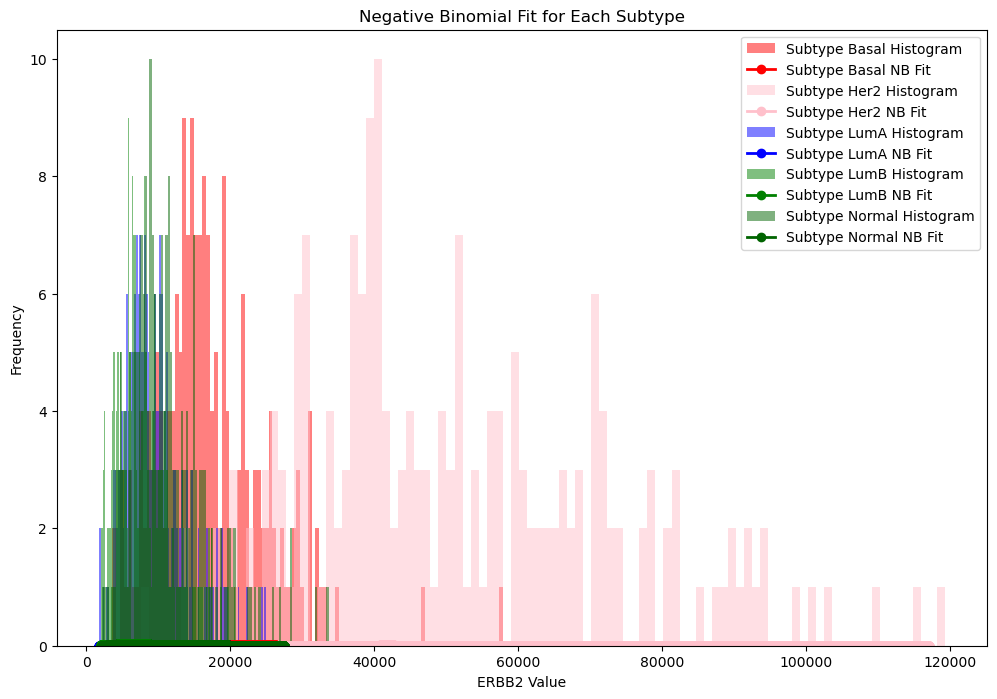

In [14]:
from scipy.stats import nbinom
grouped = df.groupby('Subtype')['ERBB2']

# Define colors for each subtype
colors = {'LumA': 'blue', 'LumB': 'green', 'Basal': 'red', 'Her2':'pink', 'Normal':'darkgreen'}

# Plot histograms
# Plot histograms and fits
plt.figure(figsize=(12, 8))

for subtype, values in grouped:
    # Calculate sample mean and variance
    sample_mean = np.mean(values)
    sample_variance = np.var(values, ddof=1)  # Use ddof=1 for sample variance

    # Estimate negative binomial parameters
    r = sample_mean**2 / (sample_variance - sample_mean)
    p = r / (r + sample_mean)

    # Define bins that align with integer data points
    bins = 100

    # Plot histogram with bins aligned to integer values
    plt.hist(values, bins=bins, alpha=0.5, color=colors[subtype], 
             label=f'Subtype {subtype} Histogram')

    # Plot the fitted negative binomial distribution
    #x = np.arange(min_value, max_value + 1)
    sample_mean = np.mean(values)
    sample_std = np.sqrt(sample_variance)

    # Define x over a limited range (e.g., mean ± 3 standard deviations)
    lower_bound = max(int(sample_mean - 3 * sample_std), min(values))
    upper_bound = min(int(sample_mean + 3 * sample_std), max(values))
    x = np.arange(lower_bound, upper_bound + 1)
    pmf_values = nbinom.pmf(x, r, p) * len(values)  # Scale PMF by number of observations
    plt.plot(x, pmf_values, 'o-', color=colors[subtype], label=f'Subtype {subtype} NB Fit', linewidth=2)

 
    print(subtype, np.min(values), np.max(values))
   

# Add labels and legend
plt.xlabel('ERBB2 Value')
plt.ylabel('Frequency')
plt.title('Negative Binomial Fit for Each Subtype')
plt.legend(loc='upper right')

# Show plot
plt.show()

In [15]:
result = df.groupby('Subtype')['ERBB2'].agg(['min', 'max'])

print(result)

          min     max
Subtype              
Basal    3557   57899
Her2     7589  119220
LumA     1785   24929
LumB     2057   20665
Normal   2138   33640


In [16]:
# lets try something similar but we go straight to the NB
pam50s = ['Basal', 'Her2', 'LumA', 'LumB', 'Normal']

pd_columns = gene_order.copy()
pd_columns.insert(0, "Subtype")

df_nb = pd.DataFrame(columns=pd_columns)

for i, subtype in enumerate(pam50s):

    pats_to_generate = np.sum(selected_indices_train == i)

    for j in range(pats_to_generate):
        nb_values = []

        for gene, mean_omega in vector_of_omegas[subtype]:

            mu = l * mean_omega
            r = theta  # Dispersion parameter
            # Compute the probability of success
            p = r / (r + mu)
            # Number of failures until the experiment is stopped
            n = r
            # Simulate Negative Binomial count
            nb_count = nbinom.rvs(n=n, p=p)
            
            nb_values.append(nb_count)
            


        #print(poisson_values)
        nb_values.insert(0, subtype)

        df_nb.loc[len(df_nb)] = nb_values


print(df_nb[['Subtype', 'ERBB2']])

    Subtype  ERBB2
0     Basal   4578
1     Basal  11711
2     Basal  20101
3     Basal  13638
4     Basal  14105
..      ...    ...
995  Normal  13900
996  Normal   8350
997  Normal  12181
998  Normal   6960
999  Normal  11426

[1000 rows x 2 columns]


In [17]:
result = df_nb.groupby('Subtype')['ERBB2'].agg(['min', 'max'])

print(result)

           min     max
Subtype               
Basal     3359   40509
Her2     10152  128082
LumA      1817   21745
LumB      1595   18630
Normal    2378   39516


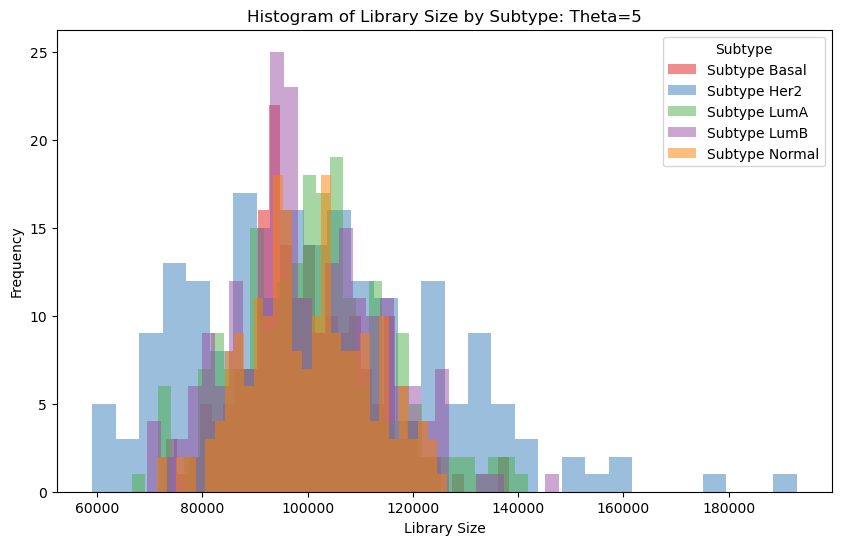

In [ ]:
# We take the results from the gamma/poisson run and create an AnnData table for PREFFECT
# add subtypes to "obs", create an adjacency matrix based on subtype
#### NOTE: Creates just 1 dataset for now, so currently set to be training ####

subtype_info = df.iloc[:, 0]

# Extract the numerical data
gamma_count_data = df.iloc[:, 1:]


adata = ad.AnnData(X=gamma_count_data.values)

# save gene names and omegas
adata.var_names = gamma_count_data.columns.values
adata.var['gene'] = adata.var_names
adata.var['her2_omega'] = [t[1] for t in vector_of_omegas['Her2']]
adata.var['basal_omega'] = [t[1] for t in vector_of_omegas['Basal']]
adata.var['luma_omega'] = [t[1] for t in vector_of_omegas['LumA']]
adata.var['lumb_omega'] = [t[1] for t in vector_of_omegas['LumB']]
adata.var['normal_omega'] = [t[1] for t in vector_of_omegas['Normal']]

# Set variable (gene) names if they exist
sample_names = ["train_tau1_" + str(i) for i in gamma_count_data.index]
adata.obs_names = sample_names
adata.obs['subtype'] = subtype_info.values

### CREATE EDGE MATRIX HERE
subtype_array = adata.obs['subtype'].to_numpy()
sample_sample_adj = (subtype_array[:, None] == subtype_array[None, :]).astype(int)

#sample_sample_adj = (adata.obs['Subtype'][:, None] == adata.obs['Subtype'][None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata.obsm['sample_sample_adj'] = sample_sample_adj_coo

# normalize library size
library_sizes = adata.X.sum(axis=1)  # Sum across columns (genes)
adjust_lib_size = False

if (adjust_lib_size):
    l_scale = 100000
    adata.X = np.round((adata.X / library_sizes[:, np.newaxis]) * l_scale)

# If we want to use this for full models, we need a sample association file
# in this instance, I know they'll be identical
sample_assocs = {
    "tau_1": sample_names,
    "tau_2": ["train_tau2_" + str(i) for i in gamma_count_data.index]
}

adata.obsm['sample_association'] = pd.DataFrame(sample_assocs, index=sample_names)


write_path = "/path/to/input/dataset_omega_subtype_2/train/"
adata.write(write_path + 'dataset_omega_based_PAM50_genes.train.tau_1.h5ad')


# aand again for validation
subtype_info = df_val.iloc[:, 0]
gamma_count_data = df_val.iloc[:, 1:]


adata_val = ad.AnnData(X=gamma_count_data.values)

# save gene names and omegas
adata_val.var_names = gamma_count_data.columns.values
adata_val.var['gene'] = adata_val.var_names
adata_val.var['her2_omega'] = [t[1] for t in vector_of_omegas['Her2']]
adata_val.var['basal_omega'] = [t[1] for t in vector_of_omegas['Basal']]
adata_val.var['luma_omega'] = [t[1] for t in vector_of_omegas['LumA']]
adata_val.var['lumb_omega'] = [t[1] for t in vector_of_omegas['LumB']]
adata_val.var['normal_omega'] = [t[1] for t in vector_of_omegas['Normal']]

# Set variable (gene) names if they exist
sample_names = ["valid_tau1_" + str(i) for i in gamma_count_data.index]
adata_val.obs_names = sample_names
adata_val.obs['subtype'] = subtype_info.values

### CREATE EDGE MATRIX HERE
subtype_array = adata_val.obs['subtype'].to_numpy()
sample_sample_adj = (subtype_array[:, None] == subtype_array[None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_val.obsm['sample_sample_adj'] = sample_sample_adj_coo

# normalize library size
library_sizes = adata_val.X.sum(axis=1)  # Sum across columns (genes)
adjust_lib_size = False

if (adjust_lib_size):
    l_scale = 100000
    adata_val.X = np.round((adata_val.X / library_sizes[:, np.newaxis]) * l_scale)

sample_assocs = {
    "tau_1": sample_names,
    "tau_2": ["valid_tau2_" + str(i) for i in gamma_count_data.index]
}

adata_val.obsm['sample_association'] = pd.DataFrame(sample_assocs, index=sample_names)


write_path = "/path/to/output/dataset_omega_subtype_2/validation/"
adata_val.write(write_path + 'dataset_omega_based_PAM50_genes.validation.tau_1.h5ad')

# checking to see if the library size is all ~100,000 like we want
# Create a DataFrame
df = pd.DataFrame({
    'LibrarySize': library_sizes,
    'Subtype': subtype_info.values
})


# Get the list of unique subtypes
unique_subtypes = df['Subtype'].unique()

# Set the figure size
plt.figure(figsize=(10, 6))

# Define colors for each subtype
colors = plt.cm.Set1(range(len(unique_subtypes)))

# Plot histograms for each subtype
for color, subtype_value in zip(colors, unique_subtypes):
    subset = df[df['Subtype'] == subtype_value]
    plt.hist(
        subset['LibrarySize'],
        bins=30,          # Adjust bins as needed
        alpha=0.5,        # Transparency
        label=f'Subtype {subtype_value}',
        color=color
    )

# Add labels and title
plt.xlabel('Library Size')
plt.ylabel('Frequency')
plt.title('Histogram of Library Size by Subtype: Theta=5')

# Display the legend
plt.legend(title='Subtype')

# Show the plot
plt.show()






Create a second set of patients selected from a stickbreak algorithm, one for each subtype

In [19]:
# Dr. Hallett's version - problem with producing negative numbers if value < epsilon
import random

def generate_frequency_vector(number_probs, sticknames):
    epsilon = 1e-8  # Small epsilon to ensure the number is strictly between l and r
    L = [[0, 1]]

    for k in range(number_probs-1):
        interval_index = random.randint(0, len(L) - 1)

        l, r = L[interval_index]
        number = random.uniform(l + epsilon, r - epsilon)

        new_intervals = [[l, number], [number, r]]

        

        L.pop(interval_index)

        L.insert(interval_index, new_intervals[1])
        L.insert(interval_index, new_intervals[0])

    freq = []
    for l in L:
        piece_of_stick = l[1] - l[0]
        # minimum in case the stick size < epsilon
        if (piece_of_stick < epsilon):
            piece_of_stick = epsilon

        freq.append(piece_of_stick)

    # give each stick a consistent order of names (to add PAM50 names)
    named_values = list(zip(sticknames, freq))
    return named_values

In [20]:
# Create 5 stickbreaks
N=50
eps = 1e-08
sigma = 1

omega_vector_basal = generate_frequency_vector(N, adata.var['gene'])
omega_vector_luma = generate_frequency_vector(N, adata.var['gene'])
omega_vector_lumb = generate_frequency_vector(N, adata.var['gene'])
omega_vector_normal = generate_frequency_vector(N, adata.var['gene'])
omega_vector_her2 = generate_frequency_vector(N, adata.var['gene'])

# Must be same order as: pam50s = ['Basal', 'Her2', 'LumA', 'LumB', 'Normal']
omega_vectors = [omega_vector_basal, omega_vector_her2, omega_vector_luma, omega_vector_lumb, omega_vector_normal]


In [21]:
# generate from those values
pd_columns = gene_order.copy()
pd_columns.insert(0, "Subtype")

df_stickbreak = pd.DataFrame(columns=pd_columns)
df_stickbreak_val = pd.DataFrame(columns=pd_columns)

for i, subtype in enumerate(pam50s):

    pats_to_generate = np.sum(selected_indices_train == i)

    for j in range(pats_to_generate):
        poisson_values, poisson_values_val = [], []

        for gene, mean_omega in omega_vectors[i]:
            shape_param = theta
            scale_param = (mean_omega*l)/theta
            g_i = np.random.gamma(shape=shape_param, scale=scale_param)
            
            # Generate a Poisson random variable 
            poisson_i = np.random.poisson(g_i)
            poisson_values.append(poisson_i)

            # validation set
            g_i = np.random.gamma(shape=shape_param, scale=scale_param)
            poisson_i = np.random.poisson(g_i)
            poisson_values_val.append(poisson_i)

        poisson_values.insert(0, subtype)
        poisson_values_val.insert(0, subtype)

        df_stickbreak.loc[len(df_stickbreak)] = poisson_values
        df_stickbreak_val.loc[len(df_stickbreak_val)] = poisson_values_val



In [22]:
print(omega_vector_basal[0])
print(omega_vector_normal[0])

print(df_stickbreak_val)

('EGFR', 0.020553137192124562)
('EGFR', 0.014990536106674142)
    Subtype  EGFR  CDH3  PHGDH  ACTR3B  FOXC1   MIA  MYC  FGFR4  MDM2  ...  \
0     Basal  1839   213     13       6      0     0  109     11    81  ...   
1     Basal  1326   159     11       5      1     0  232     38   105  ...   
2     Basal   653   119      5       2      0     0  219     30    57  ...   
3     Basal  3298   170      4       5      1     0  129     16    64  ...   
4     Basal   777   106     12       0      0     0   96     39    53  ...   
..      ...   ...   ...    ...     ...    ...   ...  ...    ...   ...  ...   
995  Normal  1623  1192    138      30     80  2521  122     64    24  ...   
996  Normal  1062  1888    313      24     58  2164   56     63    29  ...   
997  Normal  2163  2423    297      28     41  1225  108     38    18  ...   
998  Normal  1657  1829    282      31     31   794   46     13    23  ...   
999  Normal  1110  1908    202      63     30  1751   67     49    25  ...   

 

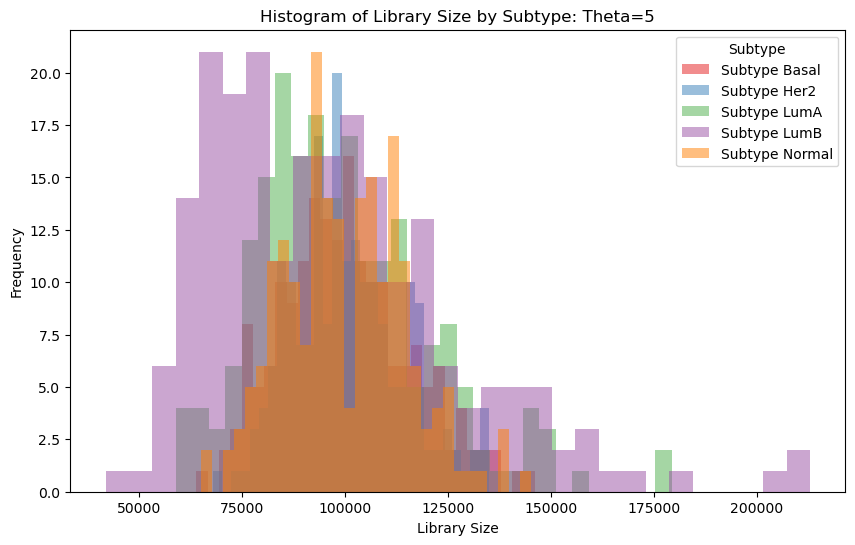

In [ ]:

subtype_info = df_stickbreak.iloc[:, 0]

# Extract the numerical data
gamma_count_data = df_stickbreak.iloc[:, 1:]


adata = ad.AnnData(X=gamma_count_data.values)


# save gene names and omegas
adata.var_names = gamma_count_data.columns.values
adata.var['gene'] = adata.var_names
adata.var['her2_omega'] = [t[1] for t in omega_vector_her2]
adata.var['basal_omega'] = [t[1] for t in omega_vector_basal]
adata.var['luma_omega'] = [t[1] for t in omega_vector_luma]
adata.var['lumb_omega'] = [t[1] for t in omega_vector_lumb]
adata.var['normal_omega'] = [t[1] for t in omega_vector_normal]

# Set variable (gene) names if they exist
sample_names = ["train_tau2_" + str(i) for i in gamma_count_data.index]
adata.obs_names = sample_names
adata.obs['subtype'] = subtype_info.values

### CREATE EDGE MATRIX HERE
subtype_array = adata.obs['subtype'].to_numpy()
sample_sample_adj = (subtype_array[:, None] == subtype_array[None, :]).astype(int)

#sample_sample_adj = (adata.obs['Subtype'][:, None] == adata.obs['Subtype'][None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata.obsm['sample_sample_adj'] = sample_sample_adj_coo



# normalize library size if desired
library_sizes = adata.X.sum(axis=1)  # Sum across columns (genes)
adjust_lib_size = False

if (adjust_lib_size):
    l_scale = 100000
    adata.X = np.round((adata.X / library_sizes[:, np.newaxis]) * l_scale)

sample_assocs = {
    "tau_1": ["train_tau1_" + str(i) for i in gamma_count_data.index],
    "tau_2": sample_names   
}

adata.obsm['sample_association'] = pd.DataFrame(sample_assocs, index=sample_names)

write_path = "/path/to/input/dataset_omega_subtype_2/train/"
adata.write(write_path + 'dataset_omega_based_PAM50_genes.train.tau_2.h5ad')

# and validation
subtype_info = df_stickbreak_val.iloc[:, 0]

gamma_count_data = df_stickbreak_val.iloc[:, 1:]
adata_val = ad.AnnData(X=gamma_count_data.values)

adata_val.var_names = gamma_count_data.columns.values
adata_val.var['gene'] = adata_val.var_names
adata_val.var['her2_omega'] = [t[1] for t in omega_vector_her2]
adata_val.var['basal_omega'] = [t[1] for t in omega_vector_basal]
adata_val.var['luma_omega'] = [t[1] for t in omega_vector_luma]
adata_val.var['lumb_omega'] = [t[1] for t in omega_vector_lumb]
adata_val.var['normal_omega'] = [t[1] for t in omega_vector_normal]

# Set variable (gene) names if they exist
sample_names = ["valid_tau2_" + str(i) for i in gamma_count_data.index]
adata_val.obs_names = sample_names
adata_val.obs['subtype'] = subtype_info.values

### CREATE EDGE MATRIX HERE
subtype_array = adata_val.obs['subtype'].to_numpy()
sample_sample_adj = (subtype_array[:, None] == subtype_array[None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_val.obsm['sample_sample_adj'] = sample_sample_adj_coo



# normalize library size if desired
library_sizes = adata_val.X.sum(axis=1)  # Sum across columns (genes)
adjust_lib_size = False

if (adjust_lib_size):
    l_scale = 100000
    adata_val.X = np.round((adata_val.X / library_sizes[:, np.newaxis]) * l_scale)

sample_assocs = {
    "tau_1": ["valid_tau1_" + str(i) for i in gamma_count_data.index],
    "tau_2": sample_names   
}

adata_val.obsm['sample_association'] = pd.DataFrame(sample_assocs, index=sample_names)

write_path = "/path/to/output/dataset_omega_subtype_2/validation/"
adata_val.write(write_path + 'dataset_omega_based_PAM50_genes.validation.tau_2.h5ad')


# Create a DataFrame
df_plot = pd.DataFrame({
    'LibrarySize': library_sizes,
    'Subtype': subtype_info.values
})

# Get the list of unique subtypes
unique_subtypes = df_plot['Subtype'].unique()

# Set the figure size
plt.figure(figsize=(10, 6))

# Define colors for each subtype
colors = plt.cm.Set1(range(len(unique_subtypes)))

# Plot histograms for each subtype
for color, subtype_value in zip(colors, unique_subtypes):
    subset = df_plot[df_plot['Subtype'] == subtype_value]
    plt.hist(
        subset['LibrarySize'],
        bins=30,          # Adjust bins as needed
        alpha=0.5,        # Transparency
        label=f'Subtype {subtype_value}',
        color=color
    )

# Add labels and title
plt.xlabel('Library Size')
plt.ylabel('Frequency')
plt.title('Histogram of Library Size by Subtype: Theta=5')

# Display the legend
plt.legend(title='Subtype')

# Show the plot
plt.show()

Testing: NB vs Gamma/Poisson

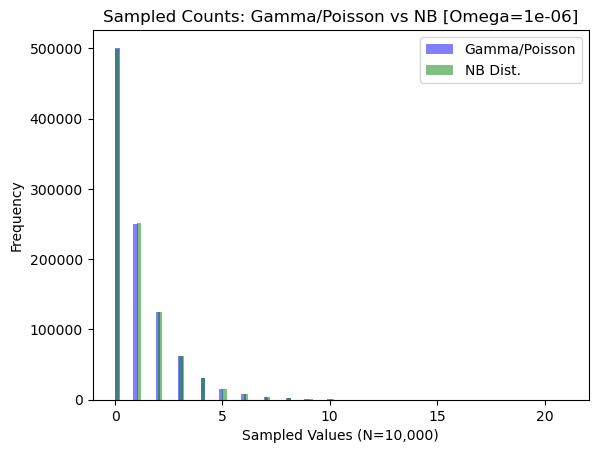

Gamma/Poisson 0 0.99951 21
NB 0 1.001009 20


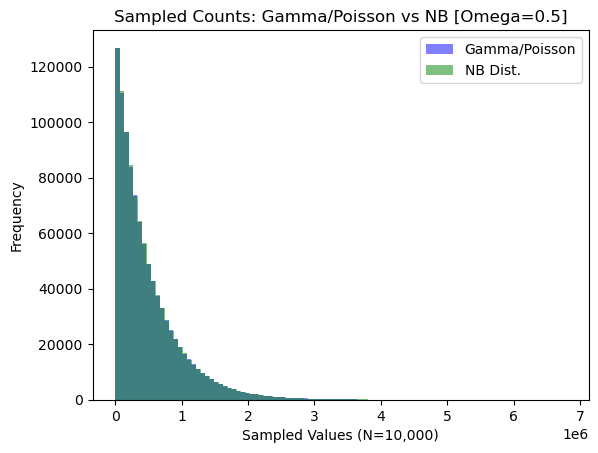

Gamma/Poisson 0 498830.921532 6736463
NB 0 500431.631766 6784022


In [ ]:

test_omegas = [0.000001, 0.5]
l = 1000000     # Replace with your actual l value
theta = 1

for i, omega in enumerate(test_omegas):

    poisson_values, nb_values = [], []

    for j in range(1000000):
        
        ### GAMMA/POISSON ###
        # Generate a gamma random variable with shape = s_i and scale = theta
        shape_param = theta
        scale_param = (omega*l)/theta

        g_i = np.random.gamma(shape=shape_param, scale=scale_param)
        
        # Compute lambda for Poisson
        lambda_i = g_i   # moved *l to the scale
        
        # Generate a Poisson random variable with parameter lambda_i
        poisson_i = np.random.poisson(lambda_i)
        
        # Store the Poisson value
        poisson_values.append(poisson_i)

        ### NEGATIVE BINOMIAL ###
        mu = l * omega
        r = theta  # Dispersion parameter
        # Compute the probability of success
        p = r / (r + mu)

        # Simulate Negative Binomial count
        nb_count = nbinom.rvs(n=r, p=p)
            
        nb_values.append(nb_count)
            
    plt.hist(poisson_values, bins=100, alpha=0.5, color='blue', label='Gamma/Poisson')
    plt.hist(nb_values, bins=100, alpha=0.5, color='green', label='NB Dist.')

    # Add labels and legend
    plt.xlabel('Sampled Values (N=10,000)')
    plt.ylabel('Frequency')
    plt.title('Sampled Counts: Gamma/Poisson vs NB [Omega=' + str(omega) + "]")
    plt.legend(loc='upper right')
    #plt.xscale('log')
    #plt.xlim(0, 400)
    # Show plot
    plt.show()    

    print("Gamma/Poisson", np.min(poisson_values), np.mean(poisson_values), np.max(poisson_values))
    print("NB", np.min(nb_values), np.mean(nb_values), np.max(nb_values))

    
